## Dog Breed Identification ##

** "You are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal of the competition is to create a classifier capable of determining a dog's breed from a photo. The list of breeds is as follows:" **

affenpinscher
afghan_hound
african_hunting_dog
airedale
american_staffordshire_terrier
appenzeller
australian_terrier
basenji
basset
beagle
bedlington_terrier
bernese_mountain_dog
black-and-tan_coonhound
blenheim_spaniel
bloodhound
bluetick
border_collie
border_terrier
borzoi
boston_bull
bouvier_des_flandres
boxer
brabancon_griffon
briard
brittany_spaniel
bull_mastiff
cairn
cardigan
chesapeake_bay_retriever
chihuahua
chow
clumber
cocker_spaniel
collie
curly-coated_retriever
dandie_dinmont
dhole
dingo
doberman
english_foxhound
english_setter
english_springer
entlebucher
eskimo_dog
flat-coated_retriever
french_bulldog
german_shepherd
german_short-haired_pointer
giant_schnauzer
golden_retriever
gordon_setter
great_dane
great_pyrenees
greater_swiss_mountain_dog
groenendael
ibizan_hound
irish_setter
irish_terrier
irish_water_spaniel
irish_wolfhound
italian_greyhound
japanese_spaniel
keeshond
kelpie
kerry_blue_terrier
komondor
kuvasz
labrador_retriever
lakeland_terrier
leonberg
lhasa
malamute
malinois
maltese_dog
mexican_hairless
miniature_pinscher
miniature_poodle
miniature_schnauzer
newfoundland
norfolk_terrier
norwegian_elkhound
norwich_terrier
old_english_sheepdog
otterhound
papillon
pekinese
pembroke
pomeranian
pug
redbone
rhodesian_ridgeback
rottweiler
saint_bernard
saluki
samoyed
schipperke
scotch_terrier
scottish_deerhound
sealyham_terrier
shetland_sheepdog
shih-tzu
siberian_husky
silky_terrier
soft-coated_wheaten_terrier
staffordshire_bullterrier
standard_poodle
standard_schnauzer
sussex_spaniel
tibetan_mastiff
tibetan_terrier
toy_poodle
toy_terrier
vizsla
walker_hound
weimaraner
welsh_springer_spaniel
west_highland_white_terrier
whippet
wire-haired_fox_terrier
yorkshire_terrier

###  File Description 

Reference: https://www.kaggle.com/c/dog-breed-identification
1. train.zip - the training set, you are provided the breed for these dogs
2. test.zip - the test set, you must predict the probability of each breed for each image
3. sample_submission.csv - a sample submission file in the correct format
4. labels.csv - the breeds for the images in the train set

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.utils import layer_utils
from keras import backend as K
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


### Import ResNet50 weights trained on ImageNet

In [ ]:
#General idea: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
#The author of this article tried to classify dogs vs cats with a pretrained model and provides an abstract idea 
model = ResNet50(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

### Add 3 hidden layers and an output layer

In [3]:
x = model.output
x = Flatten()(x)
x=Dropout(0.25)(x)
x=Dense(units=1000,activation='relu')(x)
x=Dropout(0.25)(x)
x=Dense(units=750,activation='relu')(x)
x=Dropout(0.25)(x)
x=Dense(units=750,activation='relu')(x)
x=Dropout(0.25)(x)
x=Dense(units=750,activation='relu')(x)
x=Dropout(0.25)(x)
x=Dense(units=1000,activation='relu')(x)
x=Dropout(0.6)(x)
#clf.add(Dense(units=120,activation='softmax')
#stochastic gradient descent -Adam -optimizer
#loss func categorical cross entropy
#metrics = accuracy
#clf.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
predictions = Dense(120, activation='softmax')(x)

In [4]:
import keras
main_model = Model(inputs=model.input, outputs=predictions)
#train only the hidden layers and output layer, donot train the resnet model
for curLayer in model.layers:
    curLayer.trainable = False

main_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
main_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 230, 230, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

### Image Augmentation and Model Fit

In [5]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)
#check class_mode in keras documentation https://keras.io/preprocessing/image/
training_set = train_datagen.flow_from_directory(
        '/training_images',
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        '/validation_images',
        target_size=(224, 224),
        batch_size=22,
        class_mode='categorical')

hist=main_model.fit_generator(
        training_set,
        steps_per_epoch=400,
        epochs=25,
        validation_data=test_set,
        validation_steps=101,callbacks=callbacks_list)

Found 8000 images belonging to 120 classes.
Found 2222 images belonging to 120 classes.
Epoch 1/25
400/400 [==============================] - 124s - loss: 4.7287 - acc: 0.0161 - val_loss: 5.0008 - val_acc: 0.0099
Epoch 2/25
400/400 [==============================] - 122s - loss: 4.2519 - acc: 0.0430 - val_loss: 4.1853 - val_acc: 0.0500
Epoch 3/25
400/400 [==============================] - 122s - loss: 3.8933 - acc: 0.0781 - val_loss: 3.3931 - val_acc: 0.1535
Epoch 4/25
400/400 [==============================] - 122s - loss: 3.6033 - acc: 0.1138 - val_loss: 3.0882 - val_acc: 0.1890
Epoch 5/25
400/400 [==============================] - 122s - loss: 3.3809 - acc: 0.1501 - val_loss: 2.7338 - val_acc: 0.2475
Epoch 6/25
400/400 [==============================] - 122s - loss: 3.2743 - acc: 0.1676 - val_loss: 2.7401 - val_acc: 0.2628
Epoch 7/25
400/400 [==============================] - 122s - loss: 3.1889 - acc: 0.1785 - val_loss: 2.6167 - val_acc: 0.2790
Epoch 8/25
400/400 [=================

### Obtain Predictions

In [6]:
import os
import cv2
import pandas as pd
test_set = []
test_set_ids = []
for curImage in os.listdir('/test_images'):
    test_set_ids.append(os.path.splitext(curImage)[0])
    curImage = cv2.imread('/test_images/'+curImage)
    test_set.append(cv2.resize(curImage,(224, 224)))
    
test_set = np.array(test_set, np.float32)/255.0

predictions= main_model.predict(test_set)

In [7]:
training_set.class_indices

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

### Process the Prdictions to an Output File

In [8]:
classes= {index:breed for breed,index in training_set.class_indices.items()}
column_names = [classes[i] for i in range(120)]
column_names

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [9]:
predictions_df = pd.DataFrame(predictions)
predictions_df.columns = column_names
predictions_df.insert(0,'id', test_set_ids)
predictions_df.set_index('id',inplace=True)
predictions_df

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
id,,,,,,,,,,,,,,,,,,,,,
8935ed11d71e8b349b010f715a1a790c,7.463816e-06,2.046892e-06,1.531649e-07,7.580734e-09,2.745280e-07,2.723377e-06,3.255791e-05,6.122230e-06,7.052829e-08,1.106255e-07,...,1.353153e-08,5.684334e-05,1.048956e-10,7.878602e-08,1.571382e-10,1.594295e-06,1.720573e-07,7.071010e-07,6.490301e-07,4.099139e-04
61d51637c3d950cf0a188cd536f53c87,2.411973e-02,5.220759e-03,9.404191e-03,2.339006e-02,3.792839e-03,2.253339e-03,1.660216e-02,5.369504e-03,1.630413e-03,6.175542e-04,...,7.698024e-03,8.398230e-03,1.027179e-03,8.616330e-04,1.162361e-03,1.532817e-03,6.160576e-03,4.046343e-03,9.915965e-03,3.516243e-02
16cd0ecab645b8d0629296fe0ee728f0,4.910438e-04,1.195453e-02,5.774500e-04,6.874235e-04,1.009636e-04,1.208002e-03,3.426102e-03,8.592041e-04,2.308927e-04,6.833178e-05,...,1.480073e-04,7.482538e-04,4.650196e-06,5.552061e-05,1.082942e-05,1.388973e-03,6.920570e-04,7.795199e-04,7.797452e-04,1.903534e-03
ad4870ec4771509b1562a33743621d03,1.112336e-03,2.871763e-03,1.961013e-03,9.531531e-03,9.823562e-03,4.742589e-03,4.924199e-04,2.552421e-03,1.948409e-02,1.020394e-02,...,9.710292e-04,5.423210e-04,1.462513e-02,5.650219e-03,3.192901e-02,3.819173e-03,1.439641e-04,1.245700e-02,8.257554e-04,1.050465e-03
34cc85bcee5d753514001575e6157c6e,7.718413e-04,5.357775e-04,2.475783e-02,7.337228e-03,1.789028e-02,5.362295e-03,3.002587e-03,6.248378e-02,4.640040e-03,5.889490e-03,...,2.908502e-04,3.114919e-02,1.090906e-02,4.562464e-03,7.045440e-03,2.002095e-03,1.357422e-03,2.565559e-02,4.568296e-03,3.308210e-03
c32b7011abbab8b878c9c507ec3d3ff3,3.063628e-04,5.309489e-04,1.101162e-03,7.427926e-04,2.570991e-02,2.091400e-02,3.373355e-04,4.736587e-02,3.914917e-02,5.202325e-02,...,3.929787e-05,3.835874e-02,3.112915e-03,4.284444e-02,4.683986e-03,2.547136e-02,5.437671e-04,2.489606e-02,4.036347e-03,1.740128e-03
fb05fd17b96a9d33288691701da2dffd,9.025753e-04,4.559594e-04,9.063238e-08,1.183607e-02,7.919483e-07,1.537142e-08,8.293633e-06,2.757369e-09,5.326298e-07,1.598220e-07,...,1.892301e-01,2.560713e-08,2.238319e-06,3.937430e-08,7.146737e-06,5.361218e-07,1.898101e-06,1.182730e-06,1.310589e-04,1.199792e-05
e443bb594a89ab5fa1266748d6b41648,1.144173e-02,1.337360e-02,7.774452e-05,2.069419e-02,7.041673e-05,7.879038e-05,3.350884e-04,5.628964e-06,5.165573e-05,3.517566e-05,...,4.230861e-02,6.764510e-06,4.835431e-05,1.421855e-05,1.584795e-04,9.228648e-05,2.990813e-05,9.553874e-05,4.211445e-04,6.448462e-04
8ffb64ee0970306a0b01f7a2a8da73eb,1.457666e-04,2.528805e-04,1.081589e-02,8.901916e-03,2.005071e-02,2.687336e-03,3.449740e-04,3.779630e-02,4.275640e-03,6.750184e-03,...,1.213678e-04,7.003498e-03,2.230848e-02,6.562049e-03,3.355572e-02,5.927591e-04,2.817966e-04,8.064166e-02,4.593315e-03,6.106328e-04


In [10]:
predictions_df.to_csv('/output/final_submission.csv',sep=",")

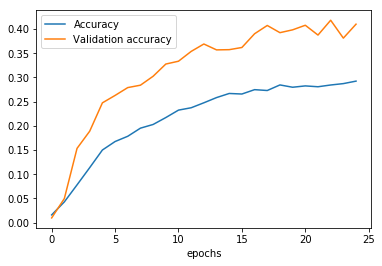

In [13]:
plt.plot(hist.history['acc'],label="Accuracy")
plt.plot(hist.history['val_acc'], label="Validation accuracy")
plt.legend()
plt.xlabel('epochs')
plt.show()

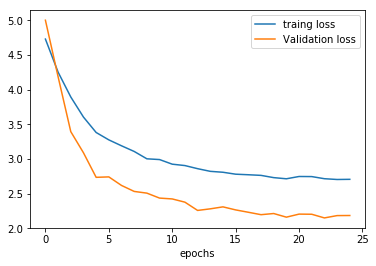

In [14]:
plt.plot(hist.history['loss'],label="traing loss")
plt.plot(hist.history['val_loss'], label="Validation loss")
plt.legend()
plt.xlabel('epochs')
plt.show()